# 🤖 BERT Fine-Tuning for Sentiment Classification

In this homework you will revisit the sentiment classification task that we did in Homework 1. However, instead of using Naive Bayes and logistic regression, you will build a neural network classifier by fine-tuning a pretrained language model. This approach to building classifiers is the current state-of-the-art, so learning how to do this should set you up very well for many future NLP problems you may want to tackle.

**Note**: As on previous assignments, you are allowed/encouraged to discuss with your classmates, but everything you submit must be your own work and you must understand everything you submit. The use of ChatGPT or other Generative AI tools is not permitted. Please list the names of everyone you worked with, as well as any resources you used.

An important goal of this assignment is to teach you how to use online documentation. The world of deep learning libraries and codebases --specifically for NLP-- is rapidly evolving as interest in the field is growing and researchers increasingly opensource their code. As a result, a critical skill of successful NLP researchers and engineers is the ability to learn how to write code on one's own by reading documentation and looking at examples. [PyTorch](https://pytorch.org/docs/stable/index.html) and [Hugging Face](https://huggingface.co/docs) have great documentation. You may use whatever documentation you'd like on this homework.

### ❗ **Remember to copy and save this notebook before starting** ❗
Citations
https://github.com/huggingface/notebooks/blob/main/transformers_doc/en/pytorch/training.ipynb
</br> https://huggingface.co/docs/transformers/model_doc/distilbert


## Imports and package installation

These are all of the packages available for use during this assignment, they're all you should need, but you are free to add others. They must first be installed on this runtime, and then imported.

In [1]:
!pip install transformers torch datasets tqdm

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import torch, codecs, random
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import datasets
from datasets import load_metric
from google.colab import output
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Dict, Any
from transformers import PreTrainedTokenizer
from torch.optim import Optimizer

output.enable_custom_widget_manager()

# Uncomment if using Drive to upload the dataset
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


If the following fails, your current Colab runtime doesn't have a GPU. To fix this, simply select 'Runtime' -> 'Change runtime type', then select 'GPU' under 'Hardware accelerator' and then press save.

In [3]:
assert torch.cuda.is_available()

## Part 1 - Dataset Preparation


### 1. Reading in the data

You will use the same dataset as in Homework 1. As a reminder, the dataset contains a total of 5,000 tweets labeled with their sentiment. The first 3,000 will be used in training. The next 1,000 will be used as a validation set, and the final 1,000 will be used for testing. The `'text'` column contains a raw Tweet, and the `'sentiment'` column contains the label (`'negative'`, `'neutral'`, or `'positive'`).

We need to load the dataset.

You can do this by uploading the dataset to this runtime:

1. Click on the 'Files' tab of the left sidebar
2. Click on the 'Upload' button that should now be exposed, and select the dataset from wherever you downloaded it
3. Change the line `read_csv(FILEPATH, ...)` to `read_csv("Tweets_5K.csv", ...)`

However, you will have to reupload the file every time your runtime changes. You can also just update the `FOLDER` variable provided to redirect to where you have the data stored in your Drive.



In [4]:
import pandas as pd

# Change this folder if you've placed the .csv elsewhere in your drive.
FOLDER = "/content/drive/MyDrive/Hw4/"  # Extend this string to point to the directory with your copy of Tweets_5K.csv
FILEPATH = f"{FOLDER}/Tweets_5K.csv"

dataset = pd.read_csv(FILEPATH, header=0, sep=',')

# X should be raw tweet text, y should be integer labels from the sentiment column ('negative': 0, 'neutral': 1, 'positive': 2)
# X: List<String>
# y: List<int> (can be list-like)
X = dataset['text'].tolist()
y = dataset['sentiment'].map({'negative':0,'neutral' : 1,'positive': 2}).tolist()

# split X and y into a train/validation/test set, use fixed-indices (3000/1000/1000)
trainset, trainlabs =  X[:3000], y[:3000]
valset, vallabs = X[3000:4000], y[3000:4000]
testset, testlabs = X[4000:], y[4000:]

### 2. Preparing the dataset


As we saw in class, the models you will be working with require the input to be structured in a very particular way (for example, BERT requires [CLS] and [SEP] tokens). To set up our data and to read it into our models, we will use Pytorch's `Dataset` and `DataLoader`, which you can read about here: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html.

This is a custom format you can use across projects. Here, we will define a child class to the Pytorch `Dataset` class, such that we can customize it for our specific dataset, and also configure the tokenizer (which we'll initialize in a moment), which will get our data set up in the format required for the models. A custom `Dataset` class requires three functions:  `__init__`, `__len__`, and `__getitem__`.  The `__getitem__` function is what will be used to fetch all training examples by the eventual dataloader. `__getitem__` will tokenize the input tweets in the BERT fashion ([CLS] and [SEP] tokens need to be inserted as discussed in lecture, etc.)

This has been written for you.

In [5]:
class TweetDataset(torch.utils.data.Dataset):
  """
  A PyTorch Dataset for our tweets that can be iterated through using __getitem__
  """
  def __init__(self, tweets : List[str], sentiments : List[int], tokenizer : PreTrainedTokenizer) -> None:
    """
    Initializes the TweetDataset from a list of tweets, their corresponding sentiments, and a tokenizer.

    Attributes
    ----------
    tweets : List[str]
      A list of tweets, where each tweet is a string
    sentiments: List[int]
      A list of sentiments represented as integers ('negative': 0, 'neutral': 1, 'positive': 2)
    tokenizer : PreTrainedTokenizer
      Any PreTrainedTokenizer from HuggingFace can be used to encode the string inputs for a model
    """
    self.tweets = tweets
    self.sentiments = sentiments
    self.tokenizer = tokenizer
    self.max_len = tokenizer.model_max_length

  def __len__(self) -> int:
    """
    Returns the number of tweets in the dataset.
    """
    return len(self.tweets)

  def __getitem__(self, index : int) -> Dict[str, Any]:
    """
    Retrieve a preprocessed data item from the dataset at the specified index.
    This is called when iterating through a TweetDataset

    Parameters:
    ----------
    index : int
        The index of the data item to retrieve.

    Returns:
    -------
    Dict[str, Any]
        A dictionary containing the preprocessed data for the given index.
        The dictionary includes the following keys:
        - 'input_ids': Encoded input IDs for the tweet.
        - 'attention_mask': Attention mask for the tweet.
        - 'labels': Sentiment label as a PyTorch tensor.
    """
    tweet = str(self.tweets[index])
    sentiments = self.sentiments[index]

    encoded_tweet = self.tokenizer.encode_plus(
      tweet,
      add_special_tokens      = True,
      max_length              = self.max_len,
      return_token_type_ids   = False,
      return_attention_mask   = True,
      return_tensors          = "pt",
      padding                 = "max_length",
      truncation              = True
    )

    return {
      'input_ids': encoded_tweet['input_ids'][0],
      'attention_mask': encoded_tweet['attention_mask'][0],
      'labels': torch.tensor(sentiments, dtype=torch.long)
    }

### 3. Tokenizer and dataloader:


Now that we have the `TweetDataset` class, you must construct the appropriate instances for our training, validation, and testing sets. Afterwhich, they must be used to construct PyTorch `DataLoader` instances (refer to PyTorch [documentation](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)).

At this point, batch sizes will have to be specified. The batch size dictates how many training instances are seen before the model's parameters are updated in gradient descent. For example, with a batch size of 32, the model will process 32 input sentences, before updating weights/parameters. Choosing the batch size may require some experimentation. The larger the batch size, the faster the models will train (because you aren't calculating gradients and updating as often). However, larger batch sizes will also use more VMEM (Video Memory, like RAM, but on a GPU). If you get an error during training or testing about running out of memory, reduce your batch sizes here. I would recommend using a batch size of 32 to start.

Finally, we'll use the distilbert-base-uncased tokenizer from Hugging Face to preprocess our tweets. This matches the model we will use down the line, and ensures our input is in the right format.

In [6]:
from transformers import AutoTokenizer
from torch.utils.data import DataLoader

# use this for the tokenizer argument of the TweetDataset
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

# define the following TweetDataset objects... be careful to split the data as previously specified
train_dataset = TweetDataset(trainset,trainlabs,tokenizer)
validation_dataset = TweetDataset(valset,vallabs,tokenizer)
test_dataset = TweetDataset(testset,testlabs,tokenizer)


# now construct DataLoader objects from the TweetDataset objects
# remember that the TweetDataset class is a child class of torch.utils.data.Dataset
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=32)
test_dataloader = DataLoader(test_dataset, batch_size=32)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


## Part 2: Untrained Model (Baseline)

In this part of the homework, you will start by working with a completely untrained model and testing how well it does on the sentiment analysis task.

### 1. Loading untrained model:

For this homework, you will be working with a model called DistilBERT, which is usually trained for a masked language modeling task. You can read more about it [here](https://huggingface.co/distilbert-base-uncased). It's basically a smaller version of BERT, which was covered in lecture (it's been '[distilled](https://arxiv.org/abs/1910.01108)').

Here, you will use the Hugging Face transformers library to load the architecture of the distilbert-base-uncased model. You want to load the UNTRAINED model, meaning you will set up the architecture, but the weights will all be randomly initialized (i.e., this is what the model looks like before any gradient descent is done).

In [7]:
from transformers import AutoConfig, AutoModelForSequenceClassification

# getting the distilbert-base-uncased config...
config = AutoConfig.from_pretrained("distilbert-base-uncased", num_labels=3)
# ...from which we can use AutoModelForSequenceClassification to instantiate
# an UNTRAINED version of the above model, read Hugging Face documentation
# to figure out how to do so!
untrained_model = AutoModelForSequenceClassification.from_config(config)

### 2. Write function to evaluate model predictions

We need to define an evaluation function, such that we can measure a model's performance on a dataset. Here, we will be looking at accuracy.

For evaluation, there are a couple of steps that must be taken. For each batch in the evaluation set:
1. Apply the model on the batch (feedforward pass through the model)
2. Obtain the predictions from the model output
3. Update the metrics and progress bar

Basically, your task is to finish the evaluate function so that it takes a model and test set and outputs what the model's accuracy is on that test set. You need not use the starter code provided, as long as the inputs/outputs match what is given.

Hugging Face documentation is your friend - the function signature is also provided.

**A note on logits**: DistilBERT's classifier outputs "logits". Logits are unnormalized predictions of a model (i.e., this is the input to the softmax function we've discussed in class). In this case, we have three classes: negative, neutral, or positive. One can assign a single output at the end of a model to each of these classes. For the purpose of this homework, we will define the model's prediction to be the class with the maximum logit value (i.e., take the argmax across the outputs). That is, the argmax of the logits is our prediction, which can be compared to the label. This may be useful when tracking metrics. Note: Softmax takes the logits as input and acts as a normalizing function, which outputs a probability distribution over the outputs. But, the argmax of the logits will be the same as the argmax of the softmax output, so no need to use softmax here.

**A note on PyTorch devices**

In PyTorch, tensor operations can be performed on devices, usually CPUs and GPUs. Tensors can be set to certain devices to optimize operations through parallelization. The operation to set a tensor to a device can be seen [here](https://pytorch.org/docs/stable/generated/torch.Tensor.to.html). Note that the returned tensor is now a copy if the device is changed. **Hint**: Setting a tensor to the correct device is necessary when using them for a model on the GPU!

In the code below, the model's parameters are loaded onto the device we are using. This gives us a way to use the GPU to run models by putting all of its parameters and computations on it!



In [8]:
# For any parameter named 'device', pass the following variable:
device = torch.device("cuda")

# Loading the model onto the device
untrained_model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [9]:
def update_metrics(metrics: List[datasets.Metric], predictions: torch.Tensor, labels: torch.Tensor) -> None:
  """
  Update a list of metrics with new predictions and labels

  Parameters:
  -----------
  metrics : List[Metric]
      List of metrics.
  predictions : torch.Tensor
      Tensor of predictions of shape (batch_size, ...)
  labels : torch.Tensor
      Tensor of labels of shape (batch_size, ...)

  Returns:
  --------
  None
  """
  # Nothing TODO here! This updates metrics based on a batch of predictions
  # and a batch of labels.
  for metric in metrics:
    metric.add_batch(predictions=predictions, references=labels)

def evaluate(model: torch.nn.Module, test_dataloader: torch.utils.data.DataLoader,
             device: torch.device, metric_strs: List[str]) -> Dict[str, float]:
  """
  Evaluate a PyTorch Model

  Parameters:
  -----------
  model : torch.nn.Module
      The model to be evaluated.
  test_dataloader : torch.utils.data.DataLoader
      DataLoader containing testing examples.
  device : torch.device
      The device that the evaluation will be performed on.
  metric_strs : List[str]
      The names of Hugging Face metrics to use.

  Returns:
  --------
  Dict[str, float]
      Dictionary of metric names mapped to their values.
  """
  # load metrics
  metrics = [load_metric(x) for x in metric_strs] # could add more here!
  model.eval()

  # we like progress bars :)
  progress_bar = tqdm(range(len(test_dataloader)))
  # HINT: progress_bar.update(1) should be used to show progress after an iteration
  progress_bar.set_description("Evaluating")
  #progress_bar.update(1)
  # TODO: Fill in the evaluate function by applying the model with the dataloader
  # HINT: Use .detach() before passing the predictions into update_metrics to prevent memory issues
  # and to send the model inputs to the device the model is on
  for batch in test_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
      outputs = model(**batch)
    predictions = torch.argmax(outputs.logits, dim=-1)
    labels = batch['labels']
    update_metrics(metrics, predictions, labels)
    progress_bar.update(1)
  # compute and return metrics (nothing TODO here)
  computed = {}
  for m in metrics:
    computed = {**computed, **m.compute()}

  return computed

### 3. Baseline performance:

*Warning: Be aware that since this is a Jupyter Notebook, sometimes it is necessary to re-execute the cell defining the models in order to restart training from scratch. Also, sometimes 'CUDA out of memory' errors are due to past models residing on the GPU, the easiest way to fix this is to restart the Colab runtime (CTRL + M + .), or to run a cell that deletes models (`del <model>`). A batch size of 32 for training should be small enough such that models train without memory issues. To change the batch size, modify the `batch_size` parameter passed when initializing the `DataLoader`.*

Now that we have an untrained model, our dataset, and an evaluation function, we can evaluate the to find our baseline accuracies! Let's see how well a model that is completely untrained does.

The next cell contains some code to make accuracy plots.

In [10]:
from scipy.stats import describe
from math import sqrt

def make_plots(perfs: List[float], names: List[str]) -> None:
  """
  Create bar plots for performance metrics.

  Parameters:
  -----------
  perfs : List[float]
      List of performance values (e.g., accuracies).
  names : List[str]
      List of names for the corresponding performance metrics.
  """
  # Nothing TODO here
  for perf, name in zip(perfs, names):
    print(f"{name} accuracy: {perf}")
  plt.bar(np.arange(len(perfs)), perfs)
  plt.xticks(np.arange(len(names)), names)
  plt.show()

Now, let's execute our evaluation loop on the testing set. In terms of metrics, we'll only keep track of accuracy for now, however you can add others to the metric list (check the Hugging Face datasets documentation).


  0%|          | 0/32 [00:00<?, ?it/s]

Baseline accuracy: 0.427


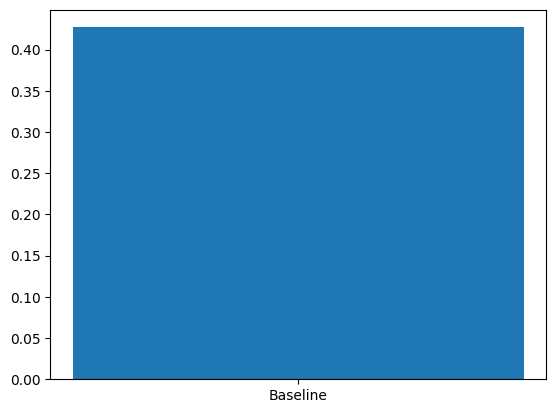

In [11]:
metrics = ['accuracy']
# TODO: evaluate on the test dataset
baseline_result = evaluate(untrained_model,test_dataloader,device,metric_strs=metrics)['accuracy']

# now, plot! Do not modify the following:
results = [baseline_result]
names = ['Baseline']
make_plots(results, names)

## Part 3 - Model trained for sentiment analysis from scatch




In this part of the homework, you will take your completely untrained model and train it to perform sentiment analysis. That is, you will update the weights so as to get as good performance as possible at predicting sentiment.

### 1. Write a function to train your model

The training loop will follow similar steps to the evaluation loop:
For each batch in each epoch (an epoch is one pass through all of the training data), you will:
1. Apply the model on the batch inputs (feedforward pass through the model)
2. Obtain the predictions, as well as the labels
3. Compare the predictions with the labels and calculate the loss
4. Backpropagate the loss and obtain gradients for all parameters
5. Update the optimizer and learning rate
6. Record the desired metrics based on the outputs and labels
In addition to this, we'd like to keep track of some metrics during each epoch, and at the end of an epoch we want to run an evaluation on the validation set (you can use the evaluation loop!). Specifically, we want to know the training accuracy (accuracy measured against the training set) and validation accuracy - they can be reported through `print` statements.

Reading [PyTorch](https://pytorch.org/docs/stable/index.html) documentation should be very useful here. We'll provide the function signature.



In [12]:
def train(model: torch.nn.Module, optimizer: Optimizer, num_epochs: int,
          train_dataloader: DataLoader, validation_dataloader: DataLoader,
          lr_scheduler: Any, device: torch.device) -> None:
  """
  Trains a model by performing a forward pass and backpropating on batches to optimize loss.

  Parameters:
  -----------
  model : torch.nn.Module
      The model to be trained.
  optimizer : torch.optim.Optimizer
      The training optimizer.
  num_epochs : int
      Number of epochs to train for.
  train_dataloader : DataLoader
      DataLoader containing training examples.
  validation_dataloader : DataLoader
      DataLoader containing validation examples.
  lr_scheduler : Any
      Learning rate scheduler.
  device : torch.device
      The device that the training will be performed on.

  Returns:
  --------
  None
  """

  # Define your loss function; Use CrossEntropyLoss
  loss_function = torch.nn.CrossEntropyLoss()

  for epoch in range(num_epochs):
    # put the model in training mode (important that this is done each epoch,
    # since we put the model into eval mode during validation)
    model.train()

    # load metrics
    metrics = [load_metric(x) for x in ["accuracy"]] # could add more here!

    print(f"Epoch {epoch + 1} training:")
    progress_bar = tqdm(range(len(train_dataloader)))

    # TODO: Fill in the rest of the train function by applying the model with the dataloader
    # HINT: Remember to use .detach() before passing model predictions to update_metrics function,
    # and to send the model inputs .to() the device that the model is on
    for batch in train_dataloader:
      batch = {k: v.to(device) for k, v in batch.items()}
      outputs = model(**batch)
      loss = outputs.loss
      loss.backward()

      optimizer.step()
      lr_scheduler.step()
      optimizer.zero_grad()
      progress_bar.update(1)
      predictions = torch.argmax(outputs.logits, dim=-1)
      update_metrics(metrics, predictions.detach(), batch['labels'])
      #for metric in metrics:
        #metric.add_batch(predictions=outputs.logits.detach(), references=batch['labels'].detach())

    # print the epoch's average metrics
    print(f"Epoch {epoch+1} average training metrics: accuracy={metrics[0].compute()['accuracy']}")

    # normally, validation would be more useful when training for many epochs
    print("Running validation:")
    # TODO: evaluate model on validation dataset
    val_metrics = evaluate(model,validation_dataloader,device,['accuracy'])['accuracy']
    #
    print(f"Epoch {epoch+1} validation: accuracy={val_metrics}")


### 2. Training the untrained model:

Great - now that we've defined our training function, we can use it to try to train the untrained model from scratch! Train the model for **2 epochs**!

**A note on warmup steps, optimizers**: An optimizer is a particular algorithm used to minimize the loss function. Optimizers like AdamW try to adapt the learning rate for individual parameters by collecting statistics about them. Warmup impacts some optimizers. Warmup steps allow the statistics calculated by some optimizers to converge before the optimizer starts to update parameters impactfully. During the warmup, the optimizer is updating parameters, but just by a much smaller magnitude than usual. Read more about optimizers [here](https://www.analyticsvidhya.com/blog/2021/10/a-comprehensive-guide-on-deep-learning-optimizers/#:~:text=While%20training%20the%20deep%20learning,loss%20and%20improve%20the%20accuracy.), and warmup [here](https://d2l.ai/chapter_optimization/lr-scheduler.html#warmup). The warmup is handled by the learning rate scheduler behind the scenes.

First, we need to set up our optimizer, learning rate scheduler, and determine the number of epochs to train for. These are all parameters to the `train` function.

In [13]:
from transformers import get_scheduler

num_epochs = 2

# TODO: use the AdamW optimizer. Use torch.optim.AdamW.
# instantiate it on the untrained model parameters with a learning rate of 5e-5
optimizer = torch.optim.AdamW(untrained_model.parameters(), lr=5e-5)

# now, we set up the learning rate scheduler
lr_scheduler = get_scheduler(
  "linear",
  optimizer=optimizer,
  num_warmup_steps=50,
  num_training_steps=len(train_dataloader) * num_epochs
)

In [14]:
torch.cuda.empty_cache()
untrained_model.to(device)

# TODO: now call your training loop!
train(untrained_model,optimizer,num_epochs,train_dataloader,validation_dataloader,lr_scheduler,device)

Epoch 1 training:


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 1 average training metrics: accuracy=0.3863333333333333
Running validation:


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1 validation: accuracy=0.447
Epoch 2 training:


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 2 average training metrics: accuracy=0.5076666666666667
Running validation:


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2 validation: accuracy=0.552


Hypothetically, the untrained model is now slightly trained.

### 3. Evaluate the trained model:

Call the evaluation loop on the model we just trained! View the bar graph to compare it to the baseline.

In [15]:
metrics = ['accuracy']

# TODO: Evaluate on test dataset!
trained_result = evaluate(untrained_model,test_dataloader,device,metrics)['accuracy']



  0%|          | 0/32 [00:00<?, ?it/s]

Baseline accuracy: 0.427
Manually Trained accuracy: 0.527


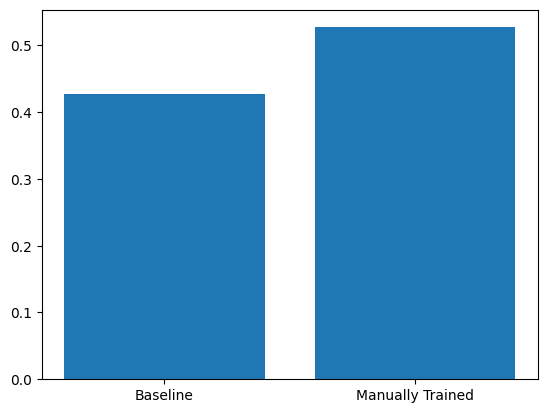

In [16]:
# now, plot! Do not modify the following:
results = baseline_result, trained_result
names = ['Baseline', 'Manually Trained']
make_plots(results, names)

As you can see, this model achieves an accuracy of around 55% after the first two epochs. Training it for further epochs (which you don't need to do) renders minimal improvement. To achieve better performance when training DistilBERT from scratch for this purpose, we'd need a lot more data and a lot more time (and/or compute). Fortunately, there is a better way!

## Part 4 - Finetuning a pre-trained model

Since manually training the model for sentiment analysis didn't work very well, let's fine-tune a pre-trained model.

### 1. Load pre-trained model:

This time, we'll make use of a pre-trained version of DistilBERT - everything's the same as before, but the model has actually already been trained for a masked language modeling task.

In [22]:
from transformers import DistilBertForSequenceClassification

# TODO: load the distilbert-base-uncased pre-trained model, use DistilBertForSequenceClassification
# from Hugging Face (transformers), read their documentation to do this.
# WARNING: This dataset has three classes! The default for this model is two!
pretrained_model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)

# Ignore the warnings printed below.

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Let's give it a test run...
To motivate, the pre-trained model isn't particularly good at this specific task out-of-the box, to see this, evaluate it on the test set just the way it is.

  0%|          | 0/32 [00:00<?, ?it/s]

Baseline accuracy: 0.427
Manually trained accuracy: 0.527
Pre-trained accuracy: 0.332


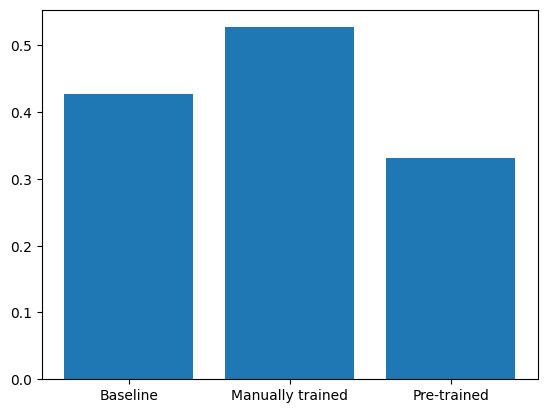

In [23]:
# We have to move it to the device before doing anything with it!
pretrained_model.to(device)

# TODO: call evaluate on the pre-trained model!
pretrained_result = evaluate(pretrained_model,test_dataloader,device,metrics)['accuracy']

# now, plot! Do not modify the following:
results = [baseline_result, trained_result, pretrained_result]
names = ['Baseline', 'Manually trained', 'Pre-trained']
make_plots(results, names)

As we can see, without any fine-tuning, the pre-trained model performs rather badly.

### 2. Fine-tuning pre-trained model:

Rather than train the model from scratch, we'll now fine-tune the pre-trained model! That is, we will take the model that was trained to predict masked words,
and now train it on our sentiment analysis task.
We'll fine-tune by simply running the `train` function on our pre-trained model with the training data! Fine-tune it for **2 epochs**.

In [24]:
num_epochs = 2

# TODO: use the same kind of optimizer as before, but with the pretrained model's parameters
optimizer = torch.optim.AdamW(pretrained_model.parameters(), lr=2e-4)

# this hasn't changed
lr_scheduler = get_scheduler(
  "linear",
  optimizer=optimizer,
  num_warmup_steps=50,
  num_training_steps=len(train_dataloader) * num_epochs
)

In [25]:
torch.cuda.empty_cache()
pretrained_model.to(device)

# TODO: train!
train(pretrained_model,optimizer,num_epochs,train_dataloader,validation_dataloader,lr_scheduler,device)

Epoch 1 training:


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 1 average training metrics: accuracy=0.6196666666666667
Running validation:


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1 validation: accuracy=0.755
Epoch 2 training:


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 2 average training metrics: accuracy=0.8096666666666666
Running validation:


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2 validation: accuracy=0.742


You should've seen a sneak-peak of the model's performance based on the validation accuracies!

### 3. Evaluating the fine-tuned model:

  0%|          | 0/32 [00:00<?, ?it/s]

Baseline accuracy: 0.427
Manually trained accuracy: 0.527
Pre-trained accuracy: 0.332
Fine-tuned accuracy: 0.759


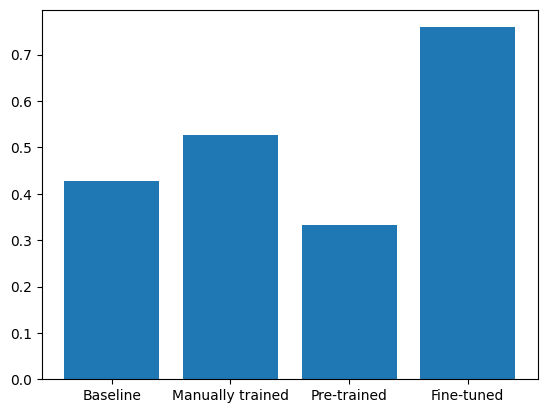

In [26]:
# TODO: Evaluate the fine-tuned model on the test dataset
finetuned_result = evaluate(pretrained_model,test_dataloader,device,metrics)['accuracy']

# now, plot! Do not modify the following:
results = [baseline_result, trained_result, pretrained_result, finetuned_result]
names = ['Baseline', 'Manually trained', 'Pre-trained', 'Fine-tuned']
make_plots(results, names)

Wow! With just two epochs of training, and only 3k training examples, we can achieve ~75% accuracy (this should be attainable)! As we can see, the pre-trained model has a very noticeable advantage over the completely untrained one. Training for an additional epoch renders a slight improvement, afterwhich the fine-tuning begins to overfit on our training set, which can be judged by comparing the average epoch training accuracies and validation accuracies.

Additionally, remember that this was the dataset used in assignment 1, where you had to do significant pre-processing to get the accuracy to just ~65%! With ease (and less training data, since here we had a 60/20/20 split), DistilBERT has an even better performance.

## Part 5 - Conceptual Questions

1. Take a look at Dataset and the BERT tokenizer (as well as their documentation). Print the output of `__getitem__` for one tweet. What does `__getitem__` return? Describe what the three components are, what their contents are (be as concrete as possible), and how they correspond to what we've seen in class. Include in your answer: describe what the numbers you see are referring to (broadly), what the zeros mean, etc. In other words, describe as concretely as possible what the input to DistilBERT needs to be.

2. For each version of the model that you evaluated, describe what that model was trained to do (if anything). Report the accuracy observed for each. Do these relative accuracies make sense to you? Briefly explain why each model performs the way it does. If a model performs well, why does it perform well? If a model performs poorly, why does it perform poorly?

3. In this assignment we've covered several methods of getting a language model to do a task (in this case, sentiment analysis): (i) Using a pretrained model off-the-shelf; (ii) Manually training a model from scratch; and (iii) Fine-tuning a pretrained model. People have to balance various factors when considering which method to adopt in deploying language models. List at least two factors that a person may wish to consider and their implications for which method(s) would be best.

How long (roughly) did it take you to complete this assignment?

Note: From here, you can make relatively easy switches. For example, you can easily sub in BERT instead of DistilBERT, or swap DistilBertForTokenClassification or DistilBertForMaskedLM or DistilBertForQuestionAnswering to consider a different task. All of NLP is at your fingertips :)

In [28]:
train_dataset.__getitem__(2)

{'input_ids': tensor([  101,  2026,  5795,  2003, 18917,  2033,  1012,  1012,  1012,   102,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   

The def __getitem__(self, index : int) -> Dict[str, Any]: returns a dictionary containing the preprocessed data for the given index.

The dictionary includes the following keys:

        - 'input_ids': Encoded input IDs for the tweet.
        - 'attention_mask': Attention mask for the tweet.
        - 'labels': Sentiment label as a PyTorch tensor.

In this assignment, we have trained multiple variations of DistilBERT. DistilBERT is a variant of BERT (Bidirectional Encoder Representations from Transformers), which is a cutting-edge natural language processing (NLP) model developed by Google. The "Distil" in DistilBERT stands for "distillation," indicating a process of condensing a large model's capabilities into a smaller, more efficient form.

DistilBERT was designed to be smaller and faster than the original BERT model while retaining its performance. It achieves this by using a technique called knowledge distillation, where it learns from a larger pre-trained model (like BERT) and distills the essential information into a smaller model architecture.

The first model was an untrained DistilBERT. Where the model was initialized with random weights and the data was evaluated on the same. I believe that the accuracy was 42.5% was a fluke based on the random weights, it should have performed worse.

The second model was trained DistilBERT. I believe if we had trained for more epochs and tweaked the hyperparameters further, higher accuracy could have been achieved.

The third model that was implemented was using a pre-trained DistilBERT with weights learned on a different corpus of data. The output was 33% which was unexpected as it performed worse than the baseline. It might be the case that the pre-trained model was not trained specifically for tasks such as sentiment analysis and therefore performed poorly.

The fourth and final model trained was a finetuning of a pretrainied DistilBERT. The output of 75.9% was expected as we used the relearned weights and worked on them for this specific task. I believe if we ran the model for more epochs an accuracy in the high 80% to low 90% is achievable.

Training results:

Baseline accuracy: 0.427

Manually trained accuracy: 0.527

Pre-trained accuracy: 0.332

Fine-tuned accuracy: 0.759

I believe that one should first research the task they are planning to take on. If there has been prior work done on a similar topic it is better to start where that work ended and work on it further. As we can observe in the experiment done in this assignment utilizing an existing model and finetuning it gave decent results. When building neural net models from scratch there are many things to be taken into consideration.


*   How many hidden layers?
*   What to use as an activation function?
*   How many nodes to have at each layer?

And many more. So one would have to try many permutations to achieve a satisfactory result. This is very time-consuming. So I believe it is better to start with a pre-trained model, if acceptable results are not achieved then one might go to a route to build something from the ground up.




## Hand-in:
To hand-in, first delete any debugging print statements, this helps me read your code.

Then, go to Runtime->Restart and run all to run the entire notebook with your completed code.

Finally, submit TWO files:
(1) download the notebook as a .ipynb, and
(2) go to File > Print > Save as PDF.

Upload the **.ipynb AND .pdf** to Blackboard.
